In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import molsysmt as msm
import numpy as np
import matplotlib.pyplot as plt

# RMSD

Lets load a small molecular system with a 5000 frames trajectory to show how MolSysMT gets the RMSD.

In [3]:
h5_file = msm.demo.files['pentalanine.h5']
molecular_system = msm.convert(h5_file)

/home/diego/Myopt/miniconda3/envs/MolSysMT/lib/python3.7/site-packages/tables/leaf.py:544: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = numpy.array(key)


In [4]:
msm.info(molecular_system)

form,n_atoms,n_groups,n_components,n_chains,n_molecules,n_entities,n_peptides,n_frames
molsysmt.MolSys,62,7,1,1,1,1,1,5000


In [5]:
time = msm.get(molecular_system, target='system', time=True)

The root mean squared deviation of a set of atom coordinates $\vec{R}:(\vec{r_{1}}, \vec{r_{2}}, ..., \vec{r_{n}})$, with respect to a reference set of atom coordinates $\vec{R'}:(\vec{r'_{1}}, \vec{r'_{2}}, ..., \vec{r'_{n}})$, is defined as:

\begin{equation}
\text{RMSD} (\vec{R'},\vec{R}) = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} \Vert \vec{r'_{i}} - \vec{r_{i}} \Vert ^{2}}
\end{equation}

\begin{equation}
\text{RMSD} (\vec{R'},\vec{R}) = 
\sqrt{ \frac{1}{n} \sum_{i=1}^{n} [(x'-x)^2 + (z'-z)^2 + (z'-z)^2]}
\end{equation}

These two sets of atom coordinates, with the same number of atoms, could belong to structures of two different molecular systems or could also be structures of the same system. Let see the case where the RMSD is calculated only with the backbone atoms of the structure of our molecular system at frame 100-th taking the frame 0-th as reference:

In [6]:
rmsd = msm.structure.get_rmsd(molecular_system, selection='backbone',
                              frame_indices=100, reference_frame_index=0)

There object returned is a numpy array with a single RMSD value:

In [7]:
print(rmsd)

[0.7381704258064243] nanometer


Lets get now the RMSD of every single frame in the trajectory with the same structure as reference, the one found in frame 0-th:

In [9]:
rmsd = msm.structure.get_rmsd(molecular_system, selection='backbone', frame_indices='all', reference_frame_index=0)

/home/diego/Myopt/miniconda3/envs/MolSysMT/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1333: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


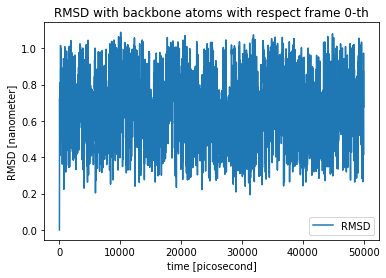

In [12]:
plt.plot(time, rmsd, label='RMSD')
plt.xlabel('time [{}]'.format(msm.puw.get_unit(time)))
plt.ylabel('RMSD [{}]'.format(msm.puw.get_unit(rmsd)))
plt.title('RMSD with backbone atoms with respect frame 0-th')
plt.legend()
plt.show()

In case of having two different molecular systems, `molsysmt.rmsd()` accepts all necessary input arguments to specify the set of atom coordinates to obtain the rmsd, for a single frame or a set of them: `item`, `selection` and `frame_indices` for the subject molecular system; and `reference_item`, `reference_selection`, and `reference_frame_index` for the reference molecular system.

Lets, for instance, create two different molecular systems (same topology in this case) to illustrate how these input arguments work:

In [13]:
molecular_system_1 = msm.extract(molecular_system, frame_indices=range(0,100))
molecular_system_2 = msm.extract(molecular_system, frame_indices=range(200,300))

In [15]:
rmsd = msm.structure.get_rmsd(molecular_system_1, selection='backbone', frame_indices=80, 
                reference_molecular_system=molecular_system_2, reference_selection='backbone',
                reference_frame_index=20)

And we got the rmsd between to structures coming from two different frames from two molecular systems:

In [16]:
print(rmsd)

[0.945975307377399] nanometer
